# Notebook for Part 1 of Modeling - Predicting Adoption Knowing How Long the Dogs Have Been at the Shelter

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
import data_cleaning as dc
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')


/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Start modeling with the dataframe that contains more breeds (ones that occur < 50 times are grouped)

In [2]:
path4 = '/Users/murdock/Documents/metis/project3/lowoccur_mergedtables.pkl'
lowoccur_df = pd.read_pickle(path4)

### Examine Different Animal Outcomes and the number of times each outcome occurs

In [3]:
outcomes = lowoccur_df['OUTCOME_TYPE'].unique()
outcomes

array(['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia', 'Died',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

In [4]:
for outcome in lowoccur_df['OUTCOME_TYPE'].unique():
    print(outcome, len(lowoccur_df[lowoccur_df['OUTCOME_TYPE'] == outcome]))

Return to Owner 9234
Transfer 7955
Adoption 15402
Euthanasia 1240
Died 117
Rto-Adopt 71
Missing 13
Disposal 11


### It appears as though some outcomes have very few occurences. For this project, the outcomes will be grouped into adopted or not adopted

In [5]:
lowoccur_df['OUTCOME_TYPE'].unique()

array(['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia', 'Died',
       'Rto-Adopt', 'Missing', 'Disposal'], dtype=object)

In [6]:
lowoccur_df['OUTCOME_TYPE'] = lowoccur_df['OUTCOME_TYPE'].apply(dc.group_outcomes)

In [7]:
lowoccur_df['OUTCOME_TYPE'].unique()

array(['Not Adopted', 'Adoption'], dtype=object)

In [8]:
le = LabelEncoder()
labels = list(le.fit_transform(list(lowoccur_df['OUTCOME_TYPE'].values)))
list(le.classes_)

['Adoption', 'Not Adopted']

In [9]:
list(le.inverse_transform([0, 1]))

['Adoption', 'Not Adopted']

Now we know that 0 is 'Adoption' and 1 is 'Not Adopted'

#### Examine unique entries for all columns of interest (before encoding)

In [10]:
lowoccur_df['SEX_ON_OUTCOME'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Female', 'Intact Male',
       'Unknown'], dtype=object)

In [11]:
lowoccur_df['COLOR'].unique()

array(['Twocolor', 'Tricolor', 'Black', 'Gold', 'Merle', 'Tan', 'Cream',
       'Red', 'White', 'Brindle', 'Brown', 'Yellow', 'Blue', 'Chocolate',
       'Tick', 'Apricot', 'Gray', 'Sable', 'Buff', 'Silver', 'Fawn',
       'Orange', 'Blue Merle', 'Brown Brindle', 'Liver', 'Agouti'], dtype=object)

In [12]:
lowoccur_df['INTAKE_TYPE'].unique()

array(['Public Assist', 'Owner Surrender', 'Stray', 'Euthanasia Request'], dtype=object)

In [13]:
lowoccur_df['INTAKE_CONDITION'].unique()

array(['Normal', 'Injured', 'Aged', 'Sick', 'Other', 'Pregnant', 'Nursing',
       'Feral'], dtype=object)

In [14]:
lowoccur_df['BREED'].unique()

array(['Other Mixed Breed', 'Dachshund', 'Other Purebred',
       'Labrador Retriever/Pit Bull', 'Miniature Schnauzer Mix',
       'Dachshund Mix', 'Border Collie Mix', 'Chihuahua Shorthair',
       'German Shepherd/Labrador Retriever', 'Staffordshire Mix',
       'Labrador Retriever Mix', 'Beagle/Labrador Retriever',
       'Rat Terrier Mix', 'German Shepherd Mix',
       'Jack Russell Terrier Mix', 'Harrier Mix', 'Pointer Mix',
       'Chihuahua Shorthair Mix', 'Australian Shepherd Mix',
       'Siberian Husky Mix', 'Chow Chow/Labrador Retriever', 'Beagle Mix',
       'Golden Retriever Mix', 'Rottweiler Mix', 'Pit Bull Mix',
       'Labrador Retriever', 'Pit Bull', 'Cocker Spaniel Mix',
       'Catahoula Mix', 'Australian Cattle Dog/Labrador Retriever',
       'Blue Lacy Mix', 'Chow Chow Mix', 'Great Pyrenees Mix',
       'German Shepherd', 'Cardigan Welsh Corgi Mix', 'Pekingese Mix',
       'Manchester Terrier Mix', 'Pomeranian Mix', 'Miniature Schnauzer',
       'Shih Tzu', 'Austra

In [15]:
len(lowoccur_df['BREED'].unique())

98

#### Encode categorical features

In [16]:
le = LabelEncoder()
lowoccur_df = dc.encode_columns(lowoccur_df, le)

In [17]:
lowoccur_df.head()

,TIME_DIFF,ID,NAME,OUTCOME_TIME,OUTCOME_TYPE,OUTCOME_SUBTYPE,SEX_ON_OUTCOME,AGE_ON_OUTCOME,BREED,COLOR,INTAKE_TIME,INTAKE_TYPE,INTAKE_CONDITION,SEX_ON_INTAKE,AGE_ON_INTAKE,rn
0,0,A006100,Scamp,2014-12-20 04:35:00,1,None,2,84.0,76,23,2014-12-19 10:21:00,2,3,2,84.0,1
1,4,A047759,Oreo,2014-04-07 03:12:00,1,Partner,2,120.0,43,22,2014-04-02 03:55:00,1,3,2,120.0,1
2,0,A134067,Bandit,2013-11-16 11:54:00,1,None,2,192.0,77,23,2013-11-16 09:02:00,2,2,2,192.0,1
3,1,A141142,Bettie,2013-11-17 11:40:00,1,None,3,180.0,61,23,2013-11-16 02:46:00,3,0,3,180.0,1
4,0,A163459,Sasha,2014-11-14 07:28:00,1,None,0,180.0,74,23,2014-11-14 03:11:00,3,3,0,180.0,1


In [18]:
len(lowoccur_df['OUTCOME_TYPE'].unique())

2

### Examine the continuous features to see if it is possible to bin them

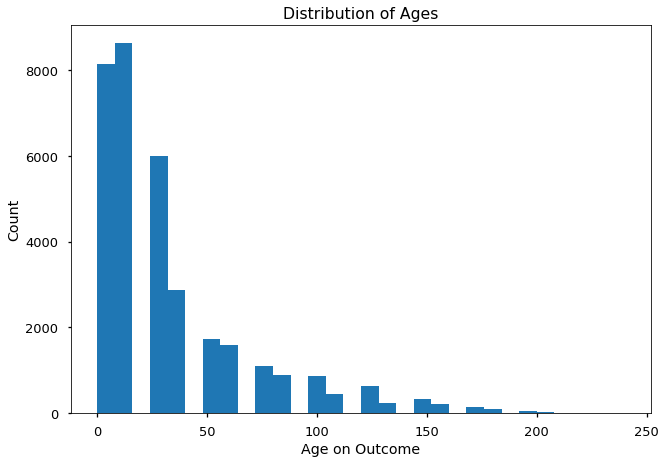

In [19]:
plt.hist(lowoccur_df['AGE_ON_OUTCOME'], bins=30)
plt.xlabel('Age on Outcome')
plt.ylabel('Count')
plt.title('Distribution of Ages');

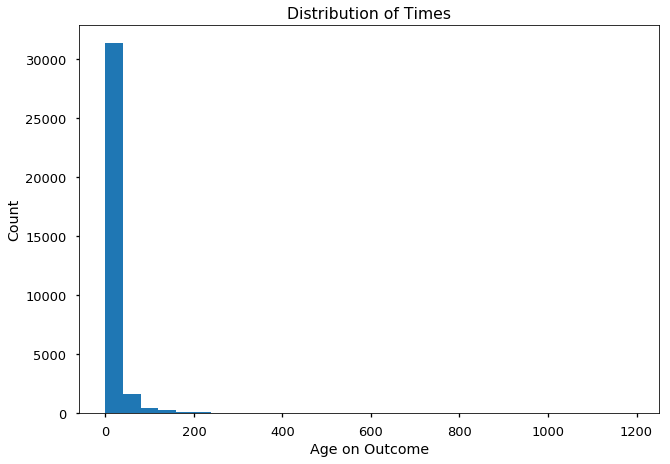

In [20]:
plt.hist(lowoccur_df['TIME_DIFF'], bins=30)
plt.xlabel('Age on Outcome')
plt.ylabel('Count')
plt.title('Distribution of Times');

It does not appear that binning will work in these cases

### Examine distribution of outcomes (base case for predicting adoption vs not)

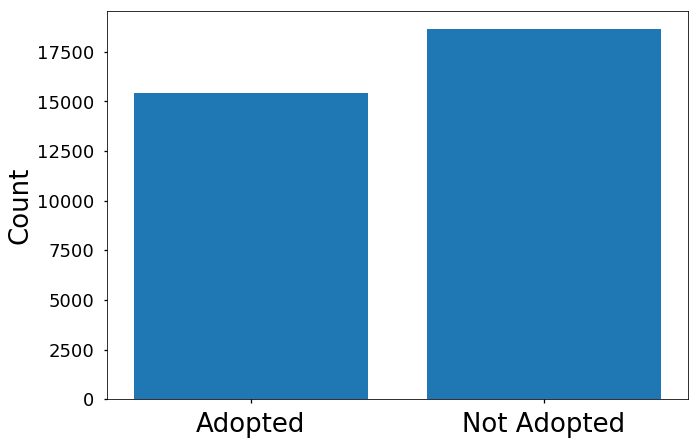

In [21]:
number_of_0 = len(lowoccur_df[lowoccur_df['OUTCOME_TYPE'] == 0])
number_of_1 = len(lowoccur_df[lowoccur_df['OUTCOME_TYPE'] == 1])
x = np.arange(2)
plt.bar(x, height= [number_of_0,number_of_1])
plt.xticks(x, ['Adopted', 'Not Adopted'], fontsize=26)
plt.yticks(fontsize=18)
plt.ylabel('Count', fontsize=26)
save_path = '/Users/murdock/Documents/metis/project3/animal_outcomes.png'
plt.savefig(save_path, bbox_inches='tight');

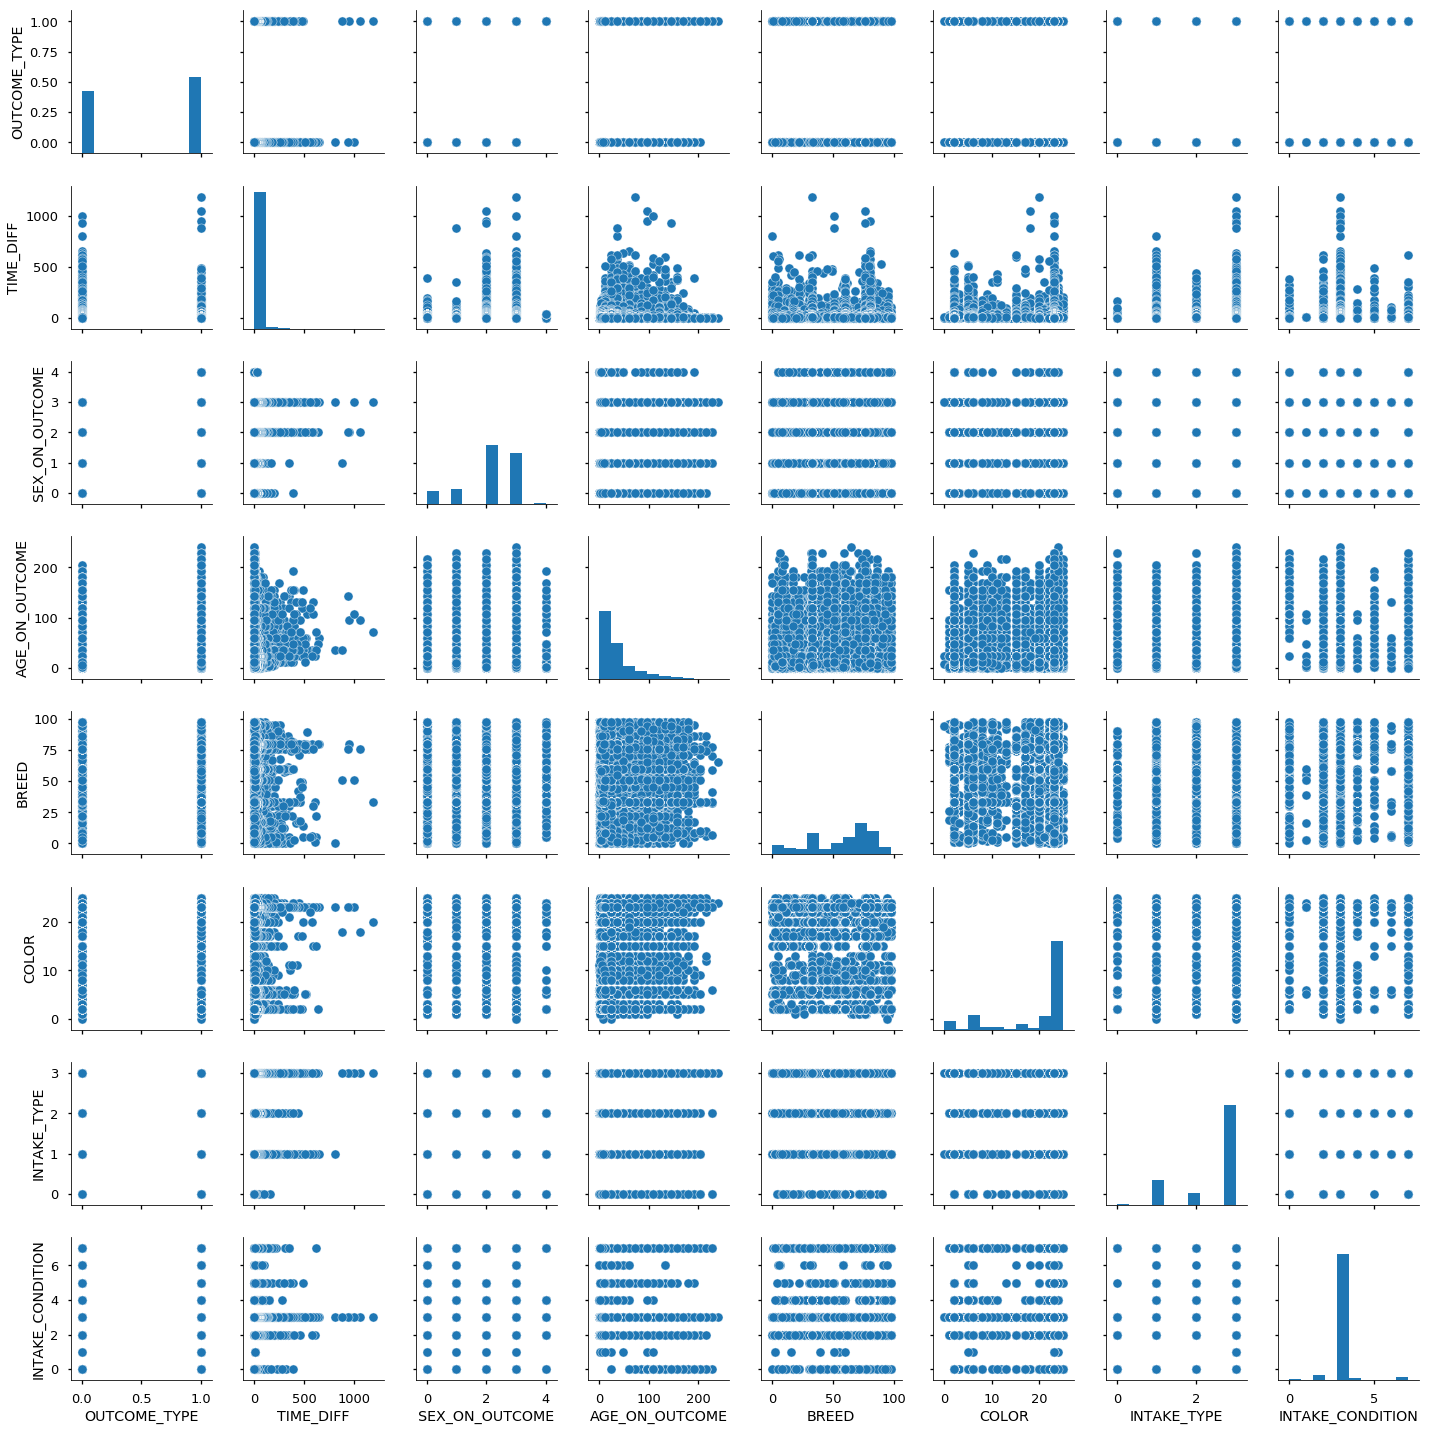

In [22]:
pairs=lowoccur_df.loc[:,['OUTCOME_TYPE', 'TIME_DIFF', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION']]

sns.pairplot(pairs)

#### Zoom in on TIME_DIFF column to see if there really is a trend with outcome_type

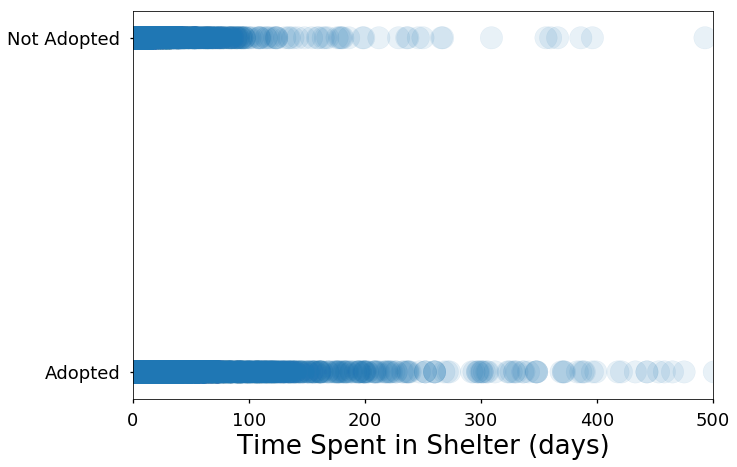

In [23]:
plt.scatter(lowoccur_df['TIME_DIFF'], lowoccur_df['OUTCOME_TYPE'], plt.xlim(0,500), alpha=0.1)
plt.xlabel('Time Spent in Shelter (days)', fontsize=26)
x = np.arange(2)
plt.yticks(x, ['Adopted', 'Not Adopted'], fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
save_path = '/Users/murdock/Documents/metis/project3/timeinshelter.png'
plt.savefig(save_path, bbox_inches='tight');

It appears as though the animals with outcome of 0 (Adopted) can spend more time in the shelter overall

### Initialize a function to graph model outcomes

In [24]:
def show_plots(model, X_test_std, y_test, y_train, folds=5):
    """
    Given a model and the test/train data, will plot the learning curves and ROC curves
    
    INPUTS:
    model - the model from sklearn to be utilized
    X_test_std - standardized X_test data from train/test split
    y_test - data from the train/test split
    y_train - data from the train/test split
    folds - how many cv folds to use when calculating a learning curve
    """
    train_sizes, train_scores, test_scores = learning_curve(model, X_test_std, y_test, cv=folds, scoring='neg_log_loss')
    train_cv_err = np.mean(train_scores, axis=1)
    test_cv_err = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_cv_err, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_cv_err, 'o-', color='k', label='Testing Score')
    plt.xlabel('Train Examples', fontsize=20)
    plt.ylabel('Score', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('Learning Curve', fontsize=24)
    plt.legend();
    
    y_train=np.ravel(y_train)
    log = model.fit(X_train_std, y_train)
    y_score=log.predict_proba(X_test_std)[:,0]
    fpr, tpr,_ = roc_curve(y_test, y_score, pos_label=0)
    roc_auc = auc(fpr, tpr)
    print('ROC_AUC:  ' + str(roc_auc))
    
    plt.figure()
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.xlabel('FPR', fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title('ROC Curve', fontsize=24);

### For modeling, pick your X and Y (features and target)

In [25]:
X=lowoccur_df.loc[:,['TIME_DIFF', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION']]
y=lowoccur_df['OUTCOME_TYPE']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=4444)
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

In [47]:
x_t_s = pd.DataFrame(X_test_std, columns = ['TIME_DIFF', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION'])
x_t_s

,TIME_DIFF,SEX_ON_OUTCOME,AGE_ON_OUTCOME,BREED,COLOR,INTAKE_TYPE,INTAKE_CONDITION
0,-0.106935,-0.077288,1.766704,0.153699,0.846360,-0.668432,-0.078303
1,-0.286604,-1.144980,1.105535,0.820983,-1.890260,0.585108,-0.078303
2,0.252405,0.990404,-0.547387,-1.337877,-1.890260,0.585108,-0.078303
3,-0.260937,-0.077288,-0.547387,-0.906105,0.572698,0.585108,-0.078303
4,-0.260937,0.990404,-0.630033,-0.984609,0.572698,0.585108,-0.078303
5,0.175403,-0.077288,1.436119,0.938739,0.572698,0.585108,-0.078303
6,-0.337939,-1.144980,0.113782,0.938739,0.572698,0.585108,-0.078303
7,-0.158269,0.990404,-0.547387,0.153699,-1.753429,0.585108,-0.078303
8,0.303739,-0.077288,-0.795325,0.781731,0.435867,0.585108,-0.078303
9,-0.158269,-0.077288,2.427873,1.370511,0.572698,-0.668432,-0.078303


Save this standard scalar. It will be needed later for the web app

In [31]:
import pickle

path = '/Users/murdock/Documents/metis/project3/'
# Dump the classifier with Pickle
pkl_filename = 'standardscalarRF.pkl'
# Open the file to save as pkl file
scalar_pkl = open(path + pkl_filename, 'wb')
pickle.dump(ss, scalar_pkl)
# Close the pickle instances
scalar_pkl.close()

In [46]:
arr = np.array([10,2,96,60,25,2,3]).reshape(1,-1)
#arr
#ss.transform(arr.reshape(1,-1))
ss.transform([[2, 20, 75, 23, 2, 3, 20]])

array([[ -0.31227149,  19.14116695,   1.18818107,  -1.29862525,
         -2.30075275,   0.58510818,  23.98949665]])

### Start modeling with Decision Tree

In [47]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_std, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [48]:
y_pred = decision_tree_model.predict(X_test_std)
y_pred2 = decision_tree_model.predict_proba(X_test_std)
print('Decision Tree Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Decision Tree Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Decision Tree Accuracy:  0.753353568981
Decision Tree Log Loss score:  7.56880114789
             precision    recall  f1-score   support

          0       0.72      0.75      0.74      4680
          1       0.78      0.75      0.77      5533

avg / total       0.75      0.75      0.75     10213



ROC_AUC:  0.757298690375


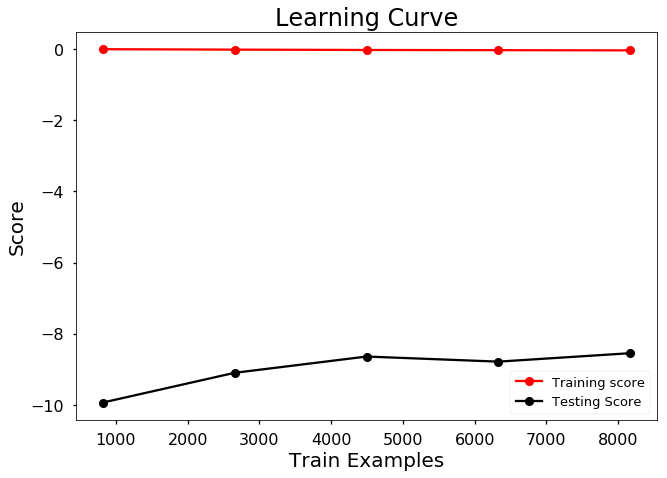

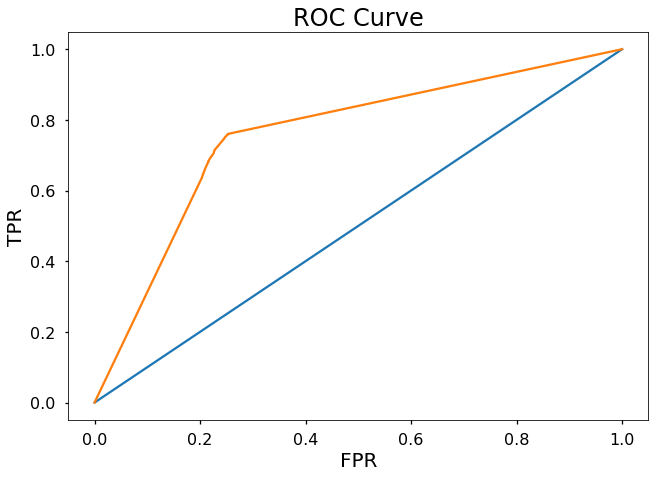

In [49]:
show_plots(decision_tree_model, X_test_std, y_test, y_train, folds=5)

#### Attempt random forest with no cross val

In [30]:
# OOB Decision function
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444, oob_score=True)
RF_model.fit(X, y)
print(RF_model.oob_score_)

0.773609846371


/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [31]:
RF_model.feature_importances_

array([ 0.33438042,  0.18028448,  0.13411935,  0.17022564,  0.07780014,
        0.08822816,  0.01496181])

## Start Modeling with Random Forest

#### Random Forest

In [32]:
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444)
RF_model.fit(X_train_std, y_train)
y_pred = RF_model.predict(X_test_std)
y_pred2 = RF_model.predict_proba(X_test_std)
print('RF Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('RF Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

RF Accuracy:  0.790561049643
RF Log Loss score:  1.43743507705
             precision    recall  f1-score   support

          0       0.75      0.82      0.78      4680
          1       0.84      0.76      0.80      5533

avg / total       0.79      0.79      0.79     10213



ROC_AUC:  0.858884745142


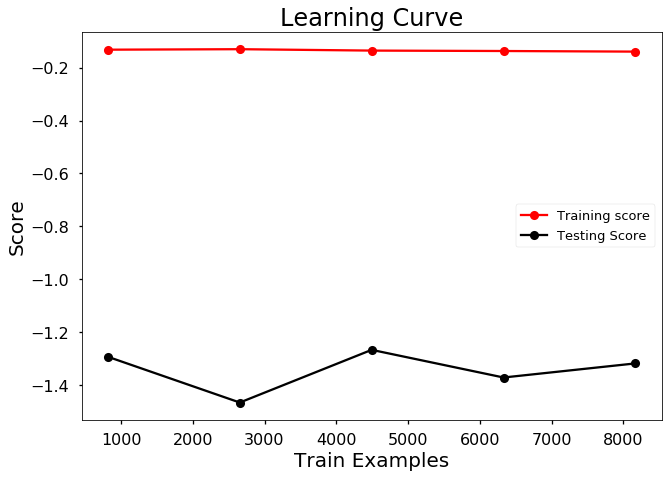

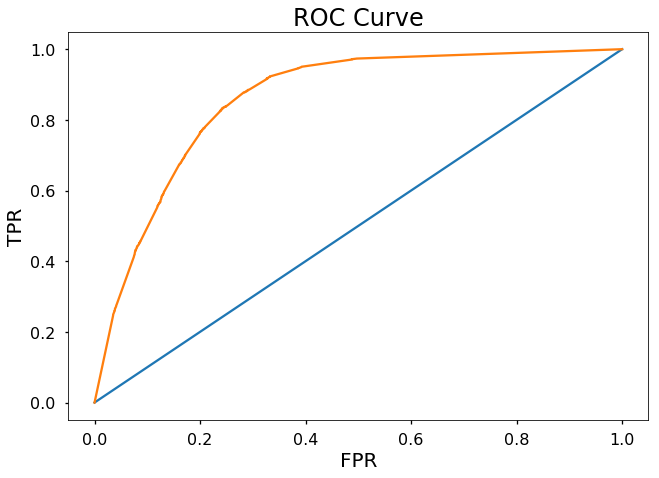

In [50]:
show_plots(RF_model, X_test_std, y_test, y_train, folds=5)

In [34]:
RF_model.feature_importances_

array([ 0.33777645,  0.17726612,  0.14468498,  0.15751196,  0.07974964,
        0.08733508,  0.01567577])

Features = ['TIME_DIFF', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION']

Therefore the TIME_DIFF, SEX_ON_OUTCOME, AGE_ON_OUTCOME, and BREED are ranked as most important

### Optimize Random Forest

#### Step 1.) target log loss as scoring metric

In [35]:
from scipy.stats import randint as sp_randint
param_dist = {"n_estimators": sp_randint(1, 200),
              "criterion": ['gini', 'entropy'],
              "max_depth": sp_randint(1, 100)}
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444)
random_search = RandomizedSearchCV(RF_model, param_distributions=param_dist, scoring='neg_log_loss', n_iter=20)

In [36]:
random_search.fit(X_train_std, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4444,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11ce44e48>, 'criterion': ['gini', 'entropy'], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11ce44f28>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='neg_log_loss', verbose=0)

In [37]:
random_search.best_params_

{'criterion': 'gini', 'max_depth': 7, 'n_estimators': 129}

In [38]:
random_search.best_score_

-0.42244885813601357

In [39]:
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444, criterion='gini')
parameters = {'max_depth': [4, 6, 8, 10, 12], 'n_estimators': [120, 125, 130, 135, 140]}
grid = GridSearchCV(RF_model,parameters, cv=5, scoring='neg_log_loss', n_jobs=1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4444,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 6, 8, 10, 12], 'n_estimators': [120, 125, 130, 135, 140]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [40]:
best_RF = grid.best_estimator_

In [41]:
y_pred = best_RF.predict(X_test_std)
y_pred2 = best_RF.predict_proba(X_test_std)
print('RF Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('RF Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

RF Accuracy:  0.810046019779
RF Log Loss score:  0.404311745687
             precision    recall  f1-score   support

          0       0.73      0.93      0.82      4680
          1       0.92      0.71      0.80      5533

avg / total       0.83      0.81      0.81     10213



ROC_AUC:  0.88837999586


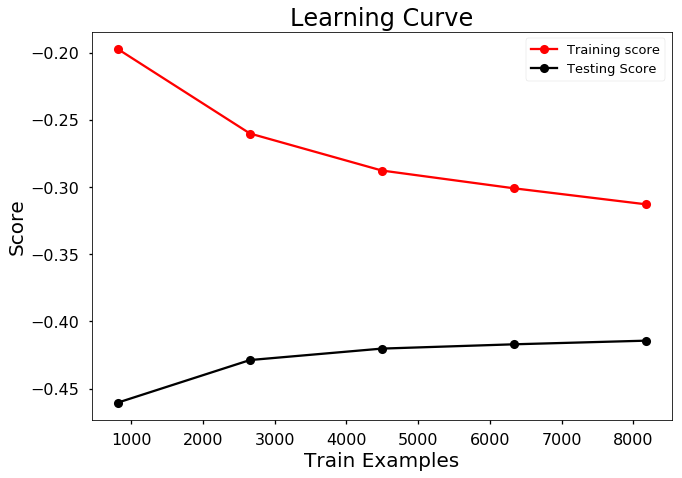

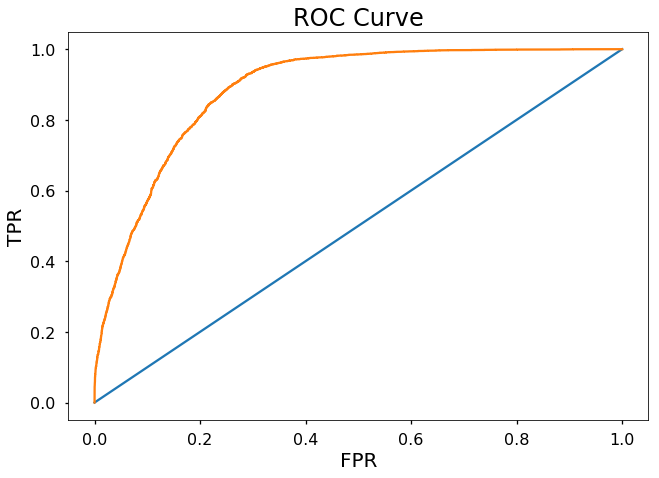

In [51]:
show_plots(best_RF, X_test_std, y_test, y_train, folds=5)

ROC_AUC:  0.88837999586


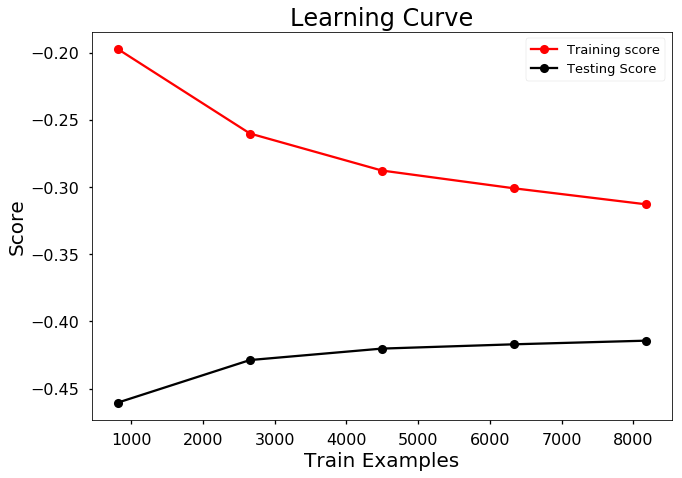

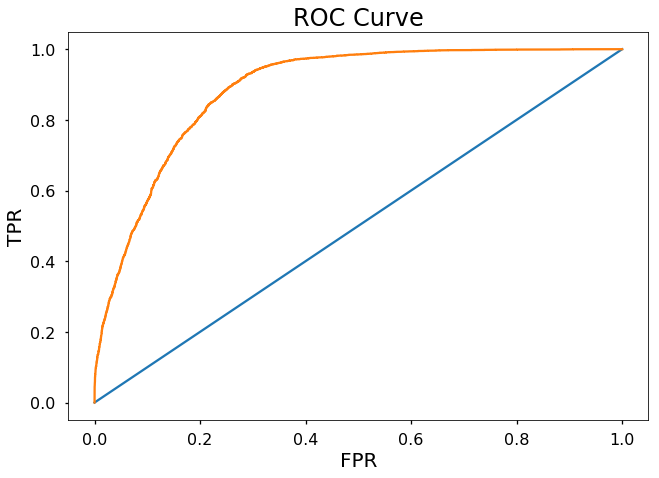

In [52]:
figure = show_plots(best_RF, X_test_std, y_test, y_train, folds=5)
save_path = '/Users/murdock/Documents/metis/project3/learncurveRF.png'
plt.savefig(save_path, bbox_inches='tight')

In [53]:
best_RF.feature_importances_

array([ 0.35655986,  0.29198319,  0.12628095,  0.04670698,  0.02327132,
        0.13871104,  0.01648666])

0.99999999999999989

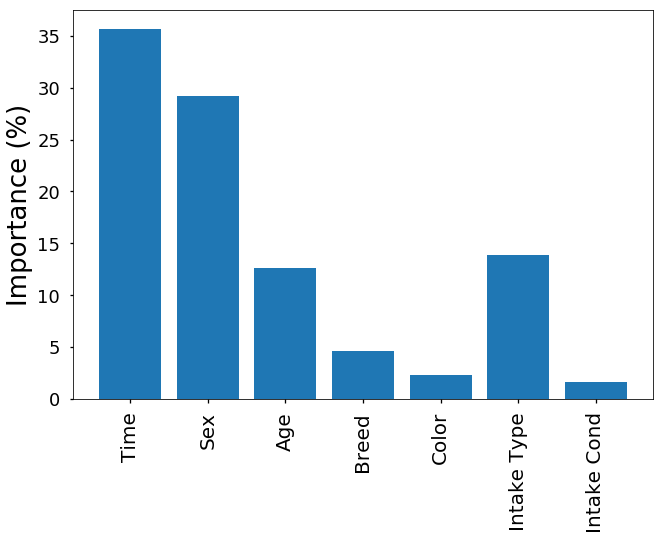

In [133]:
importances = np.array([0.35655986, 0.29198319, 0.12628095, 0.04670698, 0.02327132, 0.13871104, 0.01648666])

x = np.arange(7)
plt.bar(x, height=(importances*100))
plt.xticks(x, ['Time', 'Sex', 'Age', 'Breed', 'Color', 'Intake Type', 'Intake Cond'], fontsize=20, rotation=90)
plt.yticks(fontsize=18)
plt.ylabel('Importance (%)', fontsize=26)
save_path = '/Users/murdock/Documents/metis/project3/RFfeat_imp.png'
plt.savefig(save_path, bbox_inches='tight');

In [ ]:
number_of_0 = len(lowoccur_df[lowoccur_df['OUTCOME_TYPE'] == 0])
number_of_1 = len(lowoccur_df[lowoccur_df['OUTCOME_TYPE'] == 1])
x = np.arange(2)
plt.bar(x, height= [number_of_0,number_of_1])
plt.xticks(x, ['Adopted', 'Not Adopted'], fontsize=26)
plt.yticks(fontsize=18)
plt.ylabel('Count', fontsize=26)
save_path = '/Users/murdock/Documents/metis/project3/animal_outcomes.png'
plt.savefig(save_path, bbox_inches='tight');

Features are 'TIME_DIFF', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION'

#### Therefore the time_diff, sex_on_outcome, age, and intake_type are most important

### Graph probabilities

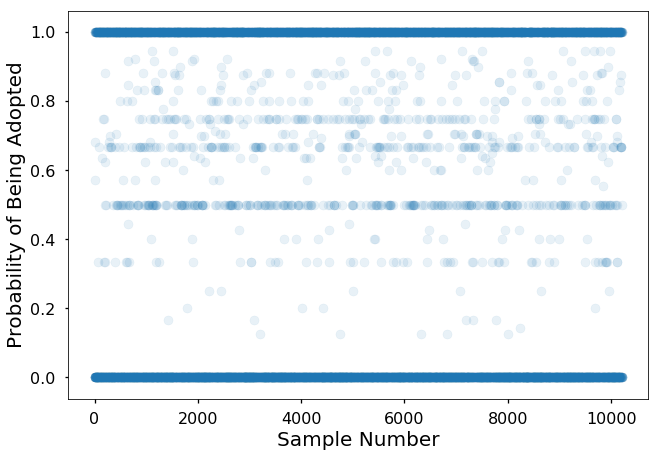

In [54]:
x = [i for i in range(1, 10214)]
plt.scatter(x, y_pred2[:,0], alpha=0.1)
plt.xlabel('Sample Number', fontsize=20)
plt.ylabel('Probability of Being Adopted', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
save_path = '/Users/murdock/Documents/metis/project3/rfpredictproba.png'
plt.savefig(save_path, bbox_inches='tight');

In [56]:
best_RF.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=135, n_jobs=1, oob_score=False, random_state=4444,
            verbose=0, warm_start=False)

### Since this model is performing well, lets pickle it to save it

In [58]:
import pickle

path = '/Users/murdock/Documents/metis/project3/'
# Dump the classifier with Pickle
pkl_filename = 'RF_current_day.pkl'
# Open the file to save as pkl file
model_pkl = open(path + pkl_filename, 'wb')
pickle.dump(best_RF, model_pkl)
# Close the pickle instances
model_pkl.close()

## Before looking at other models, need to make a dataframe with dummy variables instead of label encoding

In [59]:
path4 = '/Users/murdock/Documents/metis/project3/lowoccur_mergedtables.pkl'
lowoccur_dummy_df = pd.read_pickle(path4)

In [60]:
lowoccur_dummy_df.head()

,TIME_DIFF,ID,NAME,OUTCOME_TIME,OUTCOME_TYPE,OUTCOME_SUBTYPE,SEX_ON_OUTCOME,AGE_ON_OUTCOME,BREED,COLOR,INTAKE_TIME,INTAKE_TYPE,INTAKE_CONDITION,SEX_ON_INTAKE,AGE_ON_INTAKE,rn
0,0 days 18:14:00,A006100,Scamp,2014-12-20 04:35:00,Return to Owner,None,Neutered Male,84.0,Other Mixed Breed,Twocolor,2014-12-19 10:21:00,Public Assist,Normal,Neutered Male,84.0,1
1,4 days 23:17:00,A047759,Oreo,2014-04-07 03:12:00,Transfer,Partner,Neutered Male,120.0,Dachshund,Tricolor,2014-04-02 03:55:00,Owner Surrender,Normal,Neutered Male,120.0,1
2,0 days 02:52:00,A134067,Bandit,2013-11-16 11:54:00,Return to Owner,None,Neutered Male,192.0,Other Purebred,Twocolor,2013-11-16 09:02:00,Public Assist,Injured,Neutered Male,192.0,1
3,1 days 08:54:00,A141142,Bettie,2013-11-17 11:40:00,Return to Owner,None,Spayed Female,180.0,Labrador Retriever/Pit Bull,Twocolor,2013-11-16 02:46:00,Stray,Aged,Spayed Female,180.0,1
4,0 days 04:17:00,A163459,Sasha,2014-11-14 07:28:00,Return to Owner,None,Intact Female,180.0,Miniature Schnauzer Mix,Twocolor,2014-11-14 03:11:00,Stray,Normal,Intact Female,180.0,1


In [61]:
lowoccur_dummy_df['OUTCOME_TYPE'] = lowoccur_dummy_df['OUTCOME_TYPE'].apply(dc.group_outcomes)

In [62]:
lowoccur_dummy_df = lowoccur_dummy_df[['TIME_DIFF', 'OUTCOME_TYPE', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION', 'SEX_ON_INTAKE', 'AGE_ON_INTAKE']]

In [63]:
lowoccur_dummy_df.head()

,TIME_DIFF,OUTCOME_TYPE,SEX_ON_OUTCOME,AGE_ON_OUTCOME,BREED,COLOR,INTAKE_TYPE,INTAKE_CONDITION,SEX_ON_INTAKE,AGE_ON_INTAKE
0,0 days 18:14:00,Not Adopted,Neutered Male,84.0,Other Mixed Breed,Twocolor,Public Assist,Normal,Neutered Male,84.0
1,4 days 23:17:00,Not Adopted,Neutered Male,120.0,Dachshund,Tricolor,Owner Surrender,Normal,Neutered Male,120.0
2,0 days 02:52:00,Not Adopted,Neutered Male,192.0,Other Purebred,Twocolor,Public Assist,Injured,Neutered Male,192.0
3,1 days 08:54:00,Not Adopted,Spayed Female,180.0,Labrador Retriever/Pit Bull,Twocolor,Stray,Aged,Spayed Female,180.0
4,0 days 04:17:00,Not Adopted,Intact Female,180.0,Miniature Schnauzer Mix,Twocolor,Stray,Normal,Intact Female,180.0


In [64]:
lowoccur_dummy_df = pd.get_dummies(lowoccur_dummy_df, columns=['SEX_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION', 'SEX_ON_INTAKE'])

In [65]:
lowoccur_dummy_df.head()

,TIME_DIFF,OUTCOME_TYPE,AGE_ON_OUTCOME,AGE_ON_INTAKE,SEX_ON_OUTCOME_Intact Female,SEX_ON_OUTCOME_Intact Male,SEX_ON_OUTCOME_Neutered Male,SEX_ON_OUTCOME_Spayed Female,SEX_ON_OUTCOME_Unknown,BREED_American Bulldog Mix,...,INTAKE_CONDITION_Normal,INTAKE_CONDITION_Nursing,INTAKE_CONDITION_Other,INTAKE_CONDITION_Pregnant,INTAKE_CONDITION_Sick,SEX_ON_INTAKE_Intact Female,SEX_ON_INTAKE_Intact Male,SEX_ON_INTAKE_Neutered Male,SEX_ON_INTAKE_Spayed Female,SEX_ON_INTAKE_Unknown
0,0 days 18:14:00,Not Adopted,84.0,84.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,4 days 23:17:00,Not Adopted,120.0,120.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0 days 02:52:00,Not Adopted,192.0,192.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1 days 08:54:00,Not Adopted,180.0,180.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0 days 04:17:00,Not Adopted,180.0,180.0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


### Convert time_diff and outcome columns

In [66]:
le = LabelEncoder()
lowoccur_dummy_df = dc.convert_time_diff(lowoccur_dummy_df, le)

In [67]:
lowoccur_dummy_df.head()

,TIME_DIFF,OUTCOME_TYPE,AGE_ON_OUTCOME,AGE_ON_INTAKE,SEX_ON_OUTCOME_Intact Female,SEX_ON_OUTCOME_Intact Male,SEX_ON_OUTCOME_Neutered Male,SEX_ON_OUTCOME_Spayed Female,SEX_ON_OUTCOME_Unknown,BREED_American Bulldog Mix,...,INTAKE_CONDITION_Normal,INTAKE_CONDITION_Nursing,INTAKE_CONDITION_Other,INTAKE_CONDITION_Pregnant,INTAKE_CONDITION_Sick,SEX_ON_INTAKE_Intact Female,SEX_ON_INTAKE_Intact Male,SEX_ON_INTAKE_Neutered Male,SEX_ON_INTAKE_Spayed Female,SEX_ON_INTAKE_Unknown
0,0,1,84.0,84.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,4,1,120.0,120.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0,1,192.0,192.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,180.0,180.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,180.0,180.0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


### Pickle dataframe for later use

In [68]:
path5 = '/Users/murdock/Documents/metis/project3/lowoccur_with_dummies.pkl'
lowoccur_dummy_df.to_pickle(path5)

In [69]:
X = lowoccur_dummy_df[lowoccur_dummy_df.columns.difference(['OUTCOME_TYPE'])]
y= lowoccur_dummy_df['OUTCOME_TYPE']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=4444)
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

### Start Modeling with KNN

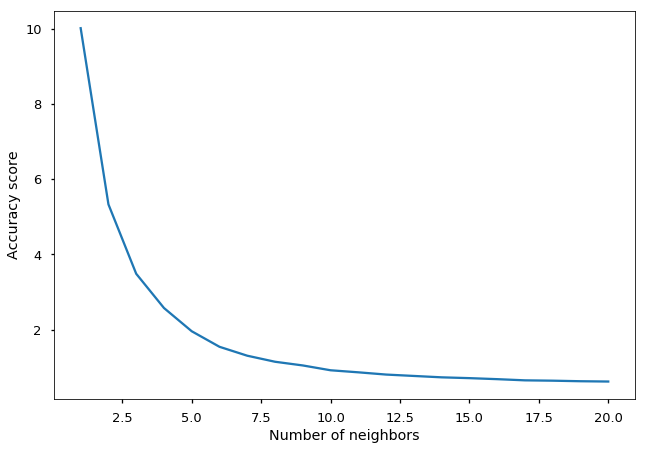

In [72]:
neighbors = np.arange(1, 21)
#neighbors = [1, 10, 15, 20]
log_loss_scores = []

for number in neighbors:
    knn = KNeighborsClassifier(n_neighbors=number)
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict_proba(X_test_std)
    log_loss_scores.append(log_loss(y_test, y_pred))

plt.plot(neighbors, log_loss_scores)
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy score');

In [74]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
y_pred2 = knn.predict_proba(X_test_std)
print('KNN Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('KNN Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

KNN Accuracy:  0.722608440223
KNN Log Loss score:  0.706932228619
             precision    recall  f1-score   support

          0       0.68      0.76      0.71      4680
          1       0.77      0.69      0.73      5533

avg / total       0.73      0.72      0.72     10213



ROC_AUC:  0.798370905105


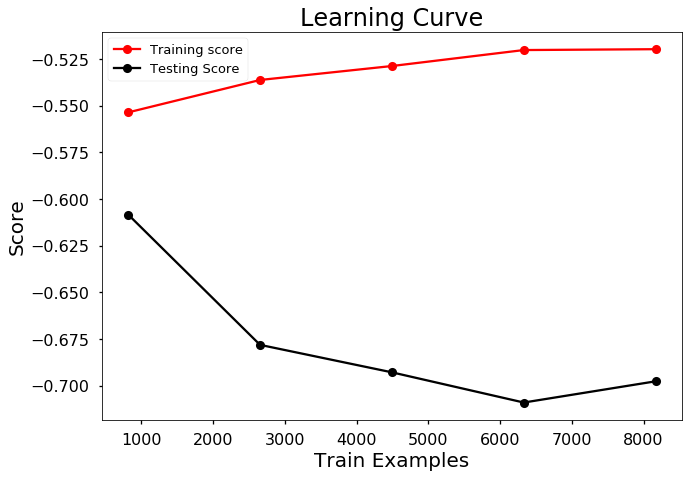

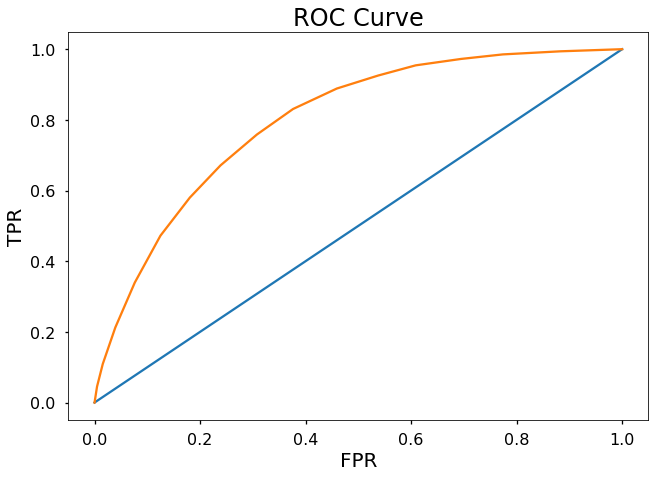

In [75]:
show_plots(knn, X_test_std, y_test, y_train, folds=5)

### Start Modeling with Logistic Regression

In [76]:
logreg = LogisticRegression()
logreg.fit(X_train_std, y_train)
y_pred = logreg.predict(X_test_std)
y_pred2 = logreg.predict_proba(X_test_std)
print('Logistic Regression Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Logistic Regression Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.78311955351
Logistic Regression Log Loss score:  0.470407268668
             precision    recall  f1-score   support

          0       0.75      0.80      0.77      4680
          1       0.82      0.77      0.79      5533

avg / total       0.79      0.78      0.78     10213



ROC_AUC:  0.853644739952


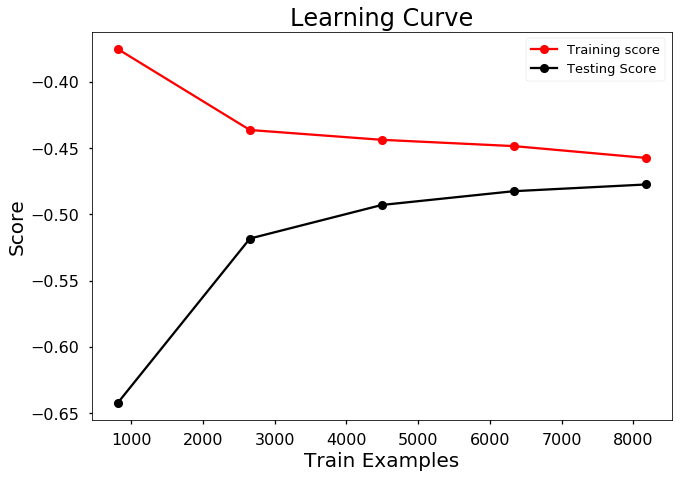

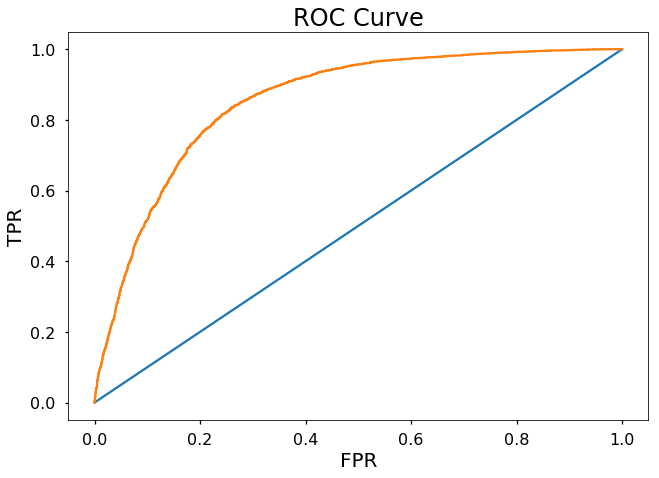

In [77]:
show_plots(logreg, X_test_std, y_test, y_train, folds=5)

### Optimize Logistic Regression

#### Step 1.) target log loss as scoring metric

In [78]:
from scipy.stats import randint as sp_randint
param_dist = {"penalty": ['l1', 'l2'],
              "C": sp_randint(1, 100),
              "fit_intercept": [True, False]}
logreg = LogisticRegression()
random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, scoring='neg_log_loss', n_iter=20)

In [79]:
random_search.fit(X_train_std, y_train)

/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: R

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11fd75ef0>, 'fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='neg_log_loss', verbose=0)

In [80]:
random_search.best_params_

{'C': 75, 'fit_intercept': True, 'penalty': 'l1'}

In [81]:
random_search.best_score_

-0.4794815759560379

In [82]:
logreg = LogisticRegression()
parameters = {"C": [70, 75, 80, 85, 90], 'penalty': ['l1', 'l2']}
grid = GridSearchCV(logreg,parameters, cv=5, scoring='neg_log_loss', n_jobs=1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [70, 75, 80, 85, 90], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [83]:
best_logreg = grid.best_estimator_

In [84]:
best_log = random_search.best_estimator_

In [85]:
y_pred = best_logreg.predict(X_test_std)
y_pred2 = best_logreg.predict_proba(X_test_std)
print('Logistic Regression Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Logistic Regression Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.78311955351
Logistic Regression Log Loss score:  0.4704493133
             precision    recall  f1-score   support

          0       0.75      0.80      0.77      4680
          1       0.82      0.77      0.79      5533

avg / total       0.79      0.78      0.78     10213



ROC_AUC:  0.853615351404


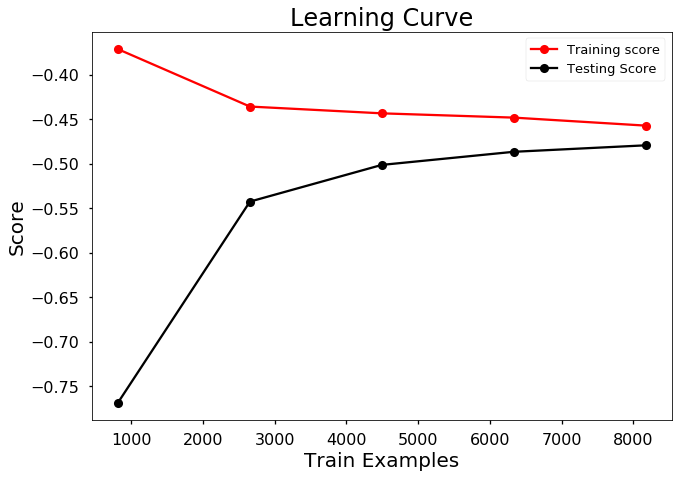

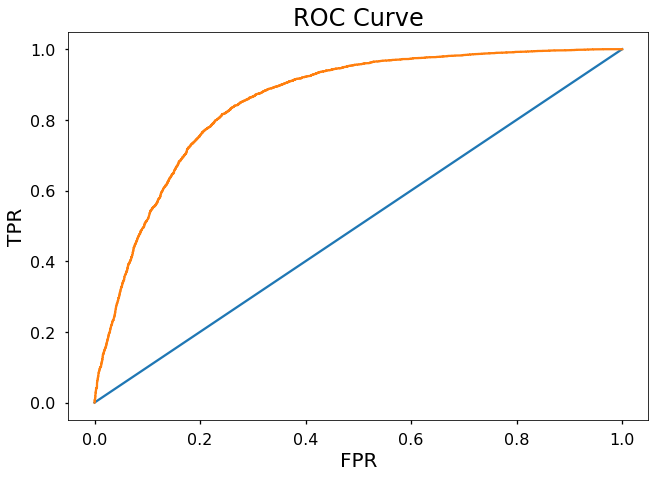

In [86]:
show_plots(best_log, X_test_std, y_test, y_train, folds=5)

### Try Naive Bayes

In [87]:
bayes_model = MultinomialNB()
bayes_model.fit(X_train, y_train)
y_pred = bayes_model.predict(X_test)
y_pred2 = bayes_model.predict_proba(X_test)
print('Bayes Model Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Bayes Model Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Bayes Model Accuracy:  0.707235875845
Bayes Model Log Loss score:  3.58868750625
             precision    recall  f1-score   support

          0       0.69      0.65      0.67      4680
          1       0.72      0.76      0.74      5533

avg / total       0.71      0.71      0.71     10213



## Now that modeling is complete for the first dataframe, try using the pitbull vs not pitbull dataframe

In [88]:
path3 = '/Users/murdock/Documents/metis/project3/pitbull_mergedtables.pkl'
pitbull_df = pd.read_pickle(path3)

In [89]:
pitbull_df.head()

,TIME_DIFF,ID,NAME,OUTCOME_TIME,OUTCOME_TYPE,OUTCOME_SUBTYPE,SEX_ON_OUTCOME,AGE_ON_OUTCOME,BREED,COLOR,INTAKE_TIME,INTAKE_TYPE,INTAKE_CONDITION,SEX_ON_INTAKE,AGE_ON_INTAKE,rn
0,0 days 18:14:00,A006100,Scamp,2014-12-20 04:35:00,Return to Owner,None,Neutered Male,84.0,Not Pit Bull,Twocolor,2014-12-19 10:21:00,Public Assist,Normal,Neutered Male,84.0,1
1,4 days 23:17:00,A047759,Oreo,2014-04-07 03:12:00,Transfer,Partner,Neutered Male,120.0,Not Pit Bull,Tricolor,2014-04-02 03:55:00,Owner Surrender,Normal,Neutered Male,120.0,1
2,0 days 02:52:00,A134067,Bandit,2013-11-16 11:54:00,Return to Owner,None,Neutered Male,192.0,Not Pit Bull,Twocolor,2013-11-16 09:02:00,Public Assist,Injured,Neutered Male,192.0,1
3,1 days 08:54:00,A141142,Bettie,2013-11-17 11:40:00,Return to Owner,None,Spayed Female,180.0,Pit Bull,Twocolor,2013-11-16 02:46:00,Stray,Aged,Spayed Female,180.0,1
4,0 days 04:17:00,A163459,Sasha,2014-11-14 07:28:00,Return to Owner,None,Intact Female,180.0,Not Pit Bull,Twocolor,2014-11-14 03:11:00,Stray,Normal,Intact Female,180.0,1


In [90]:
pitbull_df['OUTCOME_TYPE'] = pitbull_df['OUTCOME_TYPE'].apply(dc.group_outcomes)

In [91]:
le = LabelEncoder()
labels = list(le.fit_transform(list(pitbull_df['OUTCOME_TYPE'].values)))
list(le.classes_)

['Adoption', 'Not Adopted']

In [92]:
list(le.inverse_transform([0, 1]))

['Adoption', 'Not Adopted']

In [93]:
le = LabelEncoder()
pitbull_df = dc.encode_columns(pitbull_df, le)

In [94]:
pitbull_df.head()

,TIME_DIFF,ID,NAME,OUTCOME_TIME,OUTCOME_TYPE,OUTCOME_SUBTYPE,SEX_ON_OUTCOME,AGE_ON_OUTCOME,BREED,COLOR,INTAKE_TIME,INTAKE_TYPE,INTAKE_CONDITION,SEX_ON_INTAKE,AGE_ON_INTAKE,rn
0,0,A006100,Scamp,2014-12-20 04:35:00,1,None,2,84.0,0,23,2014-12-19 10:21:00,2,3,2,84.0,1
1,4,A047759,Oreo,2014-04-07 03:12:00,1,Partner,2,120.0,0,22,2014-04-02 03:55:00,1,3,2,120.0,1
2,0,A134067,Bandit,2013-11-16 11:54:00,1,None,2,192.0,0,23,2013-11-16 09:02:00,2,2,2,192.0,1
3,1,A141142,Bettie,2013-11-17 11:40:00,1,None,3,180.0,1,23,2013-11-16 02:46:00,3,0,3,180.0,1
4,0,A163459,Sasha,2014-11-14 07:28:00,1,None,0,180.0,0,23,2014-11-14 03:11:00,3,3,0,180.0,1


In [95]:
pitbull_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34043 entries, 0 to 34042
Data columns (total 16 columns):
TIME_DIFF           34043 non-null int64
ID                  34043 non-null object
NAME                27895 non-null object
OUTCOME_TIME        34043 non-null datetime64[ns]
OUTCOME_TYPE        34043 non-null int64
OUTCOME_SUBTYPE     11202 non-null object
SEX_ON_OUTCOME      34043 non-null int64
AGE_ON_OUTCOME      34043 non-null float64
BREED               34043 non-null int64
COLOR               34043 non-null int64
INTAKE_TIME         34043 non-null datetime64[ns]
INTAKE_TYPE         34043 non-null int64
INTAKE_CONDITION    34043 non-null int64
SEX_ON_INTAKE       34043 non-null int64
AGE_ON_INTAKE       34043 non-null float64
rn                  34043 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(9), object(3)
memory usage: 4.2+ MB


In [96]:
X=pitbull_df.loc[:,['TIME_DIFF', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION']]
y=pitbull_df['OUTCOME_TYPE']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=4444)
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

## Start Modeling with Random Forest

#### Random Forest

In [98]:
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444)
RF_model.fit(X_train_std, y_train)
y_pred = RF_model.predict(X_test_std)
y_pred2 = RF_model.predict_proba(X_test_std)
print('RF Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('RF Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

RF Accuracy:  0.785175756389
RF Log Loss score:  1.52447225399
             precision    recall  f1-score   support

          0       0.74      0.82      0.78      4680
          1       0.83      0.76      0.79      5533

avg / total       0.79      0.79      0.79     10213



In [99]:
RF_model.feature_importances_

array([ 0.41447809,  0.20681792,  0.16393452,  0.01346141,  0.09352405,
        0.08987422,  0.01790978])

Features = ['TIME_DIFF', 'SEX_ON_OUTCOME', 'AGE_ON_OUTCOME', 'BREED', 'COLOR', 'INTAKE_TYPE', 'INTAKE_CONDITION']

Therefore the TIME_DIFF, SEX_ON_OUTCOME, AGE_ON_OUTCOME, are ranked as most important

### Optimize Random Forest - targeting accuracy

In [104]:
from scipy.stats import randint as sp_randint
param_dist = {"n_estimators": sp_randint(1, 200),
              "criterion": ['gini', 'entropy'],
              "max_depth": sp_randint(1, 100)}
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444)
random_search = RandomizedSearchCV(RF_model, param_distributions=param_dist, scoring='neg_log_loss', n_iter=20)

In [105]:
random_search.fit(X_train_std, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4444,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x132119c18>, 'criterion': ['gini', 'entropy'], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x132119e48>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='neg_log_loss', verbose=0)

In [106]:
random_search.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 22}

In [107]:
random_search.best_score_

-0.41091649230451266

In [108]:
RF_model = RandomForestClassifier(class_weight='balanced', random_state=4444, criterion='entropy')
parameters = {'max_depth': [6, 8, 10, 12, 14], 'n_estimators': [15, 20, 25, 30, 35]}
grid = GridSearchCV(RF_model,parameters, cv=5, scoring='neg_log_loss', n_jobs=1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=4444,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [6, 8, 10, 12, 14], 'n_estimators': [15, 20, 25, 30, 35]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [109]:
best_RF = grid.best_estimator_

In [110]:
y_pred = best_RF.predict(X_test_std)
y_pred2 = best_RF.predict_proba(X_test_std)
print('RF Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('RF Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

RF Accuracy:  0.808283560168
RF Log Loss score:  0.410134214661
             precision    recall  f1-score   support

          0       0.73      0.93      0.82      4680
          1       0.92      0.71      0.80      5533

avg / total       0.83      0.81      0.81     10213



In [111]:
best_RF.feature_importances_

array([ 0.35902892,  0.27801432,  0.14249443,  0.0135459 ,  0.03187974,
        0.15350092,  0.02153576])

### Not much of an improvement over the original dataframe (as far as accuracy/log loss) and breed is not an important feature according to RF


### Try Logistic Regression

In [112]:
X = lowoccur_dummy_df[lowoccur_dummy_df.columns.difference(['OUTCOME_TYPE'])]
y= lowoccur_dummy_df['OUTCOME_TYPE']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=4444)
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

In [114]:
logreg = LogisticRegression()
logreg.fit(X_train_std, y_train)
y_pred = logreg.predict(X_test_std)
y_pred2 = logreg.predict_proba(X_test_std)
print('Logistic Regression Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Logistic Regression Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.78311955351
Logistic Regression Log Loss score:  0.470407268668
             precision    recall  f1-score   support

          0       0.75      0.80      0.77      4680
          1       0.82      0.77      0.79      5533

avg / total       0.79      0.78      0.78     10213



### Optimize Logistic Regression - target log loss

In [115]:
from scipy.stats import randint as sp_randint
param_dist = {"penalty": ['l1', 'l2'],
              "C": sp_randint(1, 100),
              "fit_intercept": [True, False]}
logreg = LogisticRegression()
random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, scoring='neg_log_loss', n_iter=20)

In [116]:
random_search.fit(X_train_std, y_train)

/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/murdock/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: R

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'penalty': ['l1', 'l2'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x132119748>, 'fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='neg_log_loss', verbose=0)

In [117]:
random_search.best_params_

{'C': 5, 'fit_intercept': True, 'penalty': 'l1'}

In [118]:
random_search.best_score_

-0.4794503496861296

In [119]:
logreg = LogisticRegression()
parameters = {"C": [1, 3, 5, 7, 9]}
grid = GridSearchCV(logreg,parameters, cv=5, scoring='accuracy', n_jobs=1)
grid.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 3, 5, 7, 9]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=0)

In [120]:
best_logreg = grid.best_estimator_

In [121]:
best_log = random_search.best_estimator_

In [122]:
y_pred = best_logreg.predict(X_test_std)
y_pred2 = best_logreg.predict_proba(X_test_std)
print('Logistic Regression Accuracy:  ' + str(accuracy_score(y_test, y_pred)))
print('Logistic Regression Log Loss score:  ' + str(log_loss(y_test, y_pred2)))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.783217467933
Logistic Regression Log Loss score:  0.470469795755
             precision    recall  f1-score   support

          0       0.75      0.80      0.77      4680
          1       0.82      0.77      0.79      5533

avg / total       0.79      0.78      0.78     10213



## No real improvements on the model when looking at accuracy, therefore keep the original work on the dataframe with more breeds. 